In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from deepctr.feature_column import SparseFeat, DenseFeat, VarLenSparseFeat, get_feature_names
from deepctr.models import DeepFM

In [2]:
data = pd.read_csv("../data/food/merged_preprocessed_data.csv")

In [3]:
data.head(3)

,user_id,recipe_id,rating,year,month,day,hour,recipe_name,category,aver_rate,ingredients,cooking_directions,nutritions,tags
0,39,61727,4,2001,3,26,7,Ten Minute Enchilada Sauce,main-dish,4.439774,"['vegetable oil', 'self-rising flour', 'New Me...","['Prep', '10 m', 'Cook', '15 m', 'Ready In', '...","[1.057699, 1.901137, 408.3739, 7.002383, 0.236...","['15-minutes-or-less', 'north-american', 'sauc..."
1,39,7612,5,2004,8,2,16,Chocolate Lovers' Favorite Cake,dessert,4.683846,"[""devil's food cake mix"", 'instant chocolate p...","['Prep', '30 m', 'Cook', '1 h', 'Ready In', '2...","[2.117175, 40.40503, 608.3894, 57.70967, 0.047...","['for-large-groups', 'desserts', 'oven', 'cake..."
2,39,12009,4,2001,2,28,10,Cajun Chicken Pasta,main-dish,4.676716,"['linguine pasta', 'boneless skinless chicken ...","['Prep', '15 m', 'Cook', '15 m', 'Ready In', '...","[25.5405, 5.582606, 1134.194, 53.74738, 1.0397...","['30-minutes-or-less', 'north-american', 'main..."


In [4]:
data.shape

(151148, 14)

In [5]:
data['rating'].value_counts()

5    101162
4     49986
Name: rating, dtype: int64

In [6]:
data.isna().sum()

user_id               0
recipe_id             0
rating                0
year                  0
month                 0
day                   0
hour                  0
recipe_name           0
category              0
aver_rate             0
ingredients           0
cooking_directions    0
nutritions            0
tags                  0
dtype: int64

In [7]:
sparse_features = ['user_id', 'recipe_id', 'year', 'month', 'day', 'hour', 'category']
dense_features = ['aver_rate', 'nutritions']
varlen_features = ['ingredients', 'tags']

In [8]:
data[sparse_features] = data[sparse_features].astype(str)

In [9]:
import ast

def convert_to_list(string):
    return ast.literal_eval(string)

data['nutritions'] = data['nutritions'].apply(convert_to_list)

for feature in varlen_features:
    data[feature] = data[feature].apply(convert_to_list)

In [10]:
nutrition_array = np.array(data['nutritions'].tolist())

mms = MinMaxScaler(feature_range=(0, 1))
nutrition_scaled = mms.fit_transform(nutrition_array)

data['nutritions'] = pd.Series(nutrition_scaled.tolist())

In [11]:
data.head(3)

,user_id,recipe_id,rating,year,month,day,hour,recipe_name,category,aver_rate,ingredients,cooking_directions,nutritions,tags
0,39,61727,4,2001,3,26,7,Ten Minute Enchilada Sauce,main-dish,4.439774,"[vegetable oil, self-rising flour, New Mexico,...","['Prep', '10 m', 'Cook', '15 m', 'Ready In', '...","[0.007680581334216343, 0.004525529670195738, 0...","[15-minutes-or-less, north-american, sauces, c..."
1,39,7612,5,2004,8,2,16,Chocolate Lovers' Favorite Cake,dessert,4.683846,"[devil's food cake mix, instant chocolate pudd...","['Prep', '30 m', 'Cook', '1 h', 'Ready In', '2...","[0.015374066522015702, 0.09618147565911814, 0....","[for-large-groups, desserts, oven, cakes, choc..."
2,39,12009,4,2001,2,28,10,Cajun Chicken Pasta,main-dish,4.676716,"[linguine pasta, boneless skinless chicken bre...","['Prep', '15 m', 'Cook', '15 m', 'Ready In', '...","[0.1854647565768262, 0.013289020775468969, 0.0...","[30-minutes-or-less, north-american, main-dish..."


In [12]:
def pad_varlen(varlen_list, max_len=None):
    if not max_len:
        length = np.array([len(item) for item in varlen_list]) 
        max_len = max(length)
    return (max_len, pad_sequences(varlen_list, maxlen=max_len, padding='post', dtype=object, value=0).astype(str))

In [13]:
train, test = train_test_split(data, test_size=0.2, stratify=data['rating'])

In [14]:
(im, ingredients_train) = pad_varlen(train['ingredients'])
(tm, tags_train) = pad_varlen(train['tags'])

In [15]:
(_, ingredients_test) = pad_varlen(test['ingredients'], im)
(_, tags_test) = pad_varlen(test['tags'], tm)

In [16]:
max_length = [im, tm]

In [17]:
all_ingredients = [ingredient for sublist in train['ingredients'] for ingredient in sublist]
unique_ingredients = set(all_ingredients)
total_unique_ingredients = len(unique_ingredients)

print(f"Total number of unique ingredients: {total_unique_ingredients}")

Total number of unique ingredients: 8462


In [18]:
all_tags = [tag for sublist in train['tags'] for tag in sublist]
unique_tags = set(all_tags)
total_unique_tags = len(unique_tags)

print(f"Total number of unique ingredients: {total_unique_tags}")

Total number of unique ingredients: 450


In [19]:
vocab_size = [8463, 452]

In [20]:
len(data['nutritions'][0])

20

In [21]:
# Set hashing space for each sparse field and generate feature config for sequence feature
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique() * 5, embedding_dim=4, use_hash=True, dtype='string')
                            for feat in sparse_features]

dense_feature_columns = [DenseFeat('aver_rate', 1, ), DenseFeat('nutritions', 20, )]

varlen_feature_columns = [
    VarLenSparseFeat(SparseFeat(feat, vocabulary_size=vocab, embedding_dim=4, use_hash=True, dtype="string"),
                        maxlen=max_len, combiner='mean', )
                        for vocab, max_len, feat in zip(vocab_size, max_length, varlen_features)]

linear_feature_columns = fixlen_feature_columns + dense_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + dense_feature_columns + varlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [22]:
feature_names

['user_id',
 'recipe_id',
 'year',
 'month',
 'day',
 'hour',
 'category',
 'aver_rate',
 'nutritions',
 'ingredients',
 'tags']

In [23]:
# Generate input data for model
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

train_model_input['ingredients'] = ingredients_train
train_model_input['nutritions'] = np.array(train['nutritions'].tolist())
train_model_input['tags'] = tags_train

test_model_input['ingredients'] = ingredients_test
test_model_input['nutritions'] = np.array(test['nutritions'].tolist())
test_model_input['tags'] = tags_test

In [24]:
# Define Model,compile and train
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')

model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(train_model_input, train['rating'].values,
                    batch_size=256, epochs=50, verbose=2, validation_split=0.2, )

Epoch 1/50
378/378 - 27s - loss: 0.7580 - mse: 0.7579 - val_loss: 0.2016 - val_mse: 0.2013
Epoch 2/50
378/378 - 20s - loss: 0.1939 - mse: 0.1936 - val_loss: 0.1998 - val_mse: 0.1994
Epoch 3/50
378/378 - 20s - loss: 0.1896 - mse: 0.1890 - val_loss: 0.2006 - val_mse: 0.2000
Epoch 4/50
378/378 - 20s - loss: 0.1869 - mse: 0.1862 - val_loss: 0.2036 - val_mse: 0.2027
Epoch 5/50
378/378 - 20s - loss: 0.1844 - mse: 0.1835 - val_loss: 0.2012 - val_mse: 0.2001
Epoch 6/50
378/378 - 20s - loss: 0.1816 - mse: 0.1804 - val_loss: 0.2047 - val_mse: 0.2034
Epoch 7/50
378/378 - 20s - loss: 0.1794 - mse: 0.1780 - val_loss: 0.2060 - val_mse: 0.2046
Epoch 8/50
378/378 - 20s - loss: 0.1781 - mse: 0.1766 - val_loss: 0.2101 - val_mse: 0.2085
Epoch 9/50
378/378 - 20s - loss: 0.1759 - mse: 0.1743 - val_loss: 0.2165 - val_mse: 0.2148
Epoch 10/50
378/378 - 20s - loss: 0.1744 - mse: 0.1726 - val_loss: 0.2102 - val_mse: 0.2083
Epoch 11/50
378/378 - 19s - loss: 0.1732 - mse: 0.1712 - val_loss: 0.2118 - val_mse: 0.20

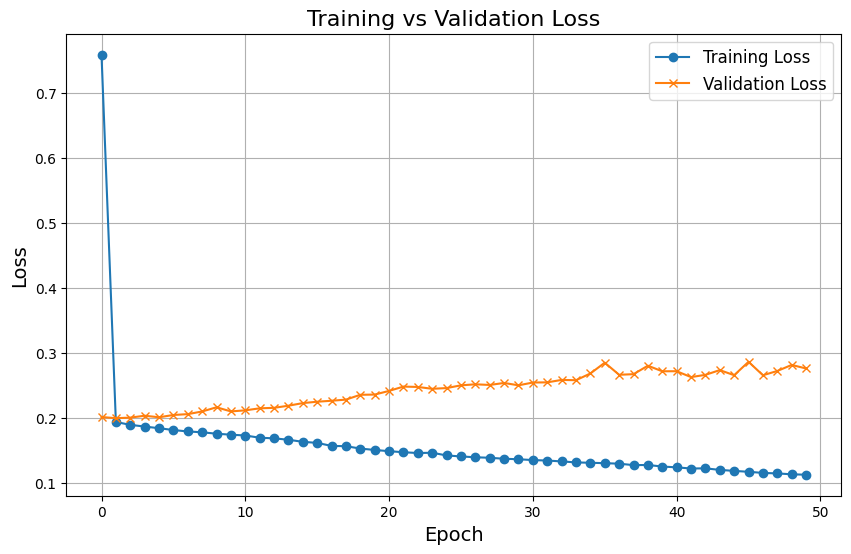

In [25]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='x')

plt.title("Training vs Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

In [26]:
# Predict
pred_ans = model.predict(test_model_input, batch_size=256)

# Evaluate Model
mse_value = mean_squared_error(test['rating'].values, pred_ans)
print("Test MSE:", round(mse_value, 4))

Test MSE: 0.271


### Self Evaluation

In [28]:
ground_truth = test['rating'].values
prediction = pred_ans
type(ground_truth), type(prediction)

(numpy.ndarray, numpy.ndarray)

In [29]:
indices = np.random.choice(10000, size=10, replace=False)
sample_array1 = ground_truth[indices]
sample_array2 = prediction[indices]

In [30]:
df = pd.DataFrame({'truth': sample_array1.flatten(), 'pred': sample_array2.flatten()})
df['diff'] = np.abs(df['truth'] - df['pred'])
df

,truth,pred,diff
0,4,4.471024,0.471024
1,5,4.693581,0.306419
2,5,4.779517,0.220483
3,5,4.471623,0.528377
4,5,4.600379,0.399621
5,4,4.662563,0.662563
6,4,4.289211,0.289211
7,4,4.533341,0.533341
8,5,4.499775,0.500225
9,4,4.314128,0.314128


### Checking with binary classifier

In [32]:
def convert_to_bin(x):
    if x == 4:
        return 0
    return 1

In [33]:
# Define Model
b_model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
b_model.compile("adam", "binary_crossentropy",
                metrics=['binary_crossentropy'], )

# Train Model
b_history = b_model.fit(train_model_input, train['rating'].apply(convert_to_bin).values,
                    batch_size=256, epochs=50, verbose=2, validation_split=0.2, )

Epoch 1/50
378/378 - 25s - loss: 0.5955 - binary_crossentropy: 0.5952 - val_loss: 0.5750 - val_binary_crossentropy: 0.5745
Epoch 2/50
378/378 - 20s - loss: 0.5571 - binary_crossentropy: 0.5564 - val_loss: 0.5795 - val_binary_crossentropy: 0.5787
Epoch 3/50
378/378 - 21s - loss: 0.5476 - binary_crossentropy: 0.5466 - val_loss: 0.5807 - val_binary_crossentropy: 0.5795
Epoch 4/50
378/378 - 20s - loss: 0.5423 - binary_crossentropy: 0.5410 - val_loss: 0.5820 - val_binary_crossentropy: 0.5805
Epoch 5/50
378/378 - 20s - loss: 0.5392 - binary_crossentropy: 0.5375 - val_loss: 0.5848 - val_binary_crossentropy: 0.5830
Epoch 6/50
378/378 - 23s - loss: 0.5362 - binary_crossentropy: 0.5342 - val_loss: 0.5913 - val_binary_crossentropy: 0.5892
Epoch 7/50
378/378 - 21s - loss: 0.5335 - binary_crossentropy: 0.5312 - val_loss: 0.5911 - val_binary_crossentropy: 0.5887
Epoch 8/50
378/378 - 20s - loss: 0.5314 - binary_crossentropy: 0.5288 - val_loss: 0.5901 - val_binary_crossentropy: 0.5874
Epoch 9/50
378/3

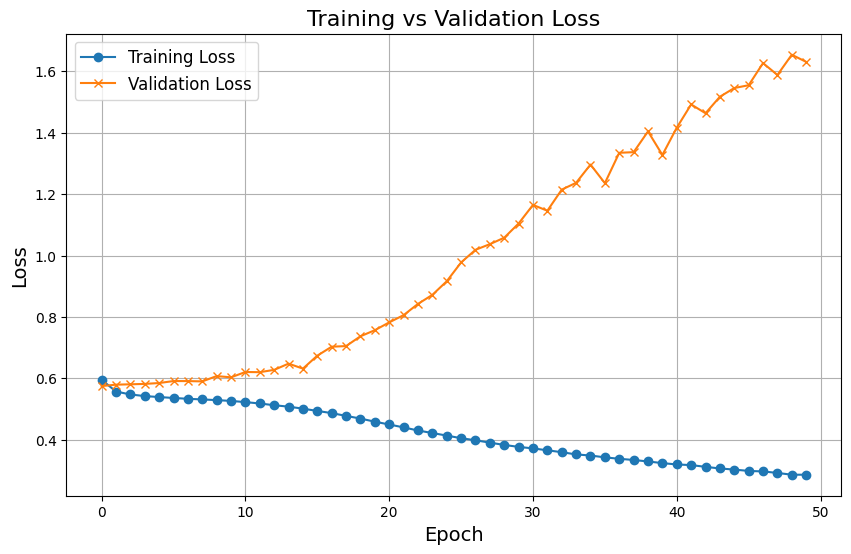

In [34]:
import matplotlib.pyplot as plt

train_loss = b_history.history['loss']
val_loss = b_history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='x')

plt.title("Training vs Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

### Inference in regression model

In [79]:
index = 23

def return_single_data(index):
    single_input_data = {
        'user_id': np.array([test_model_input['user_id'].iloc[index]]),
        'recipe_id': np.array([test_model_input['recipe_id'].iloc[index]]),
        'year': np.array([test_model_input['year'].iloc[index]]),
        'month': np.array([test_model_input['month'].iloc[index]]),
        'day': np.array([test_model_input['day'].iloc[index]]),
        'hour': np.array([test_model_input['hour'].iloc[index]]),
        'category': np.array([test_model_input['category'].iloc[index]]),
        'aver_rate': np.array([test_model_input['aver_rate'].iloc[index]]),
        'nutritions': test_model_input['nutritions'][index].reshape(1, -1),
        'ingredients': test_model_input['ingredients'][index].reshape(1, -1),
        'tags': test_model_input['tags'][index].reshape(1, -1)
    }
    return single_input_data

single_input_data = return_single_data(index)

In [80]:
single_input_data

{'user_id': array(['51226'], dtype='<U5'),
 'recipe_id': array(['228686'], dtype='<U6'),
 'year': array(['2012'], dtype='<U4'),
 'month': array(['11'], dtype='<U2'),
 'day': array(['23'], dtype='<U2'),
 'hour': array(['0'], dtype='<U1'),
 'category': array(['appetizer'], dtype='<U9'),
 'aver_rate': array([4.57894754]),
 'nutritions': array([[3.95611673e-02, 5.81941177e-03, 7.81070368e-06, 4.67971037e-03,
         3.76681778e-02, 2.28290650e-01, 7.66702013e-01, 4.14875652e-01,
         2.04133646e-04, 1.69604645e-02, 1.98033102e-02, 7.89322117e-02,
         7.70655002e-03, 9.76337546e-03, 4.32028977e-05, 0.00000000e+00,
         6.69402273e-05, 1.53972359e-02, 1.92771526e-02, 7.18303663e-02]]),
 'ingredients': array([['sweet potatoes', 'olive oil', 'brown sugar',
         'Cajun pepper seasoning', 'kosher salt', '0', '0', '0', '0', '0',
         '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
         '0', '0', '0', '0', '0']], dtype='<U111'),
 'tags': array([['60-minut

In [85]:
model.predict(single_input_data), test.iloc[index].rating

(array([[4.664038]], dtype=float32), 5)

In [86]:
model.predict(return_single_data(34)), test.iloc[34].rating

(array([[4.239792]], dtype=float32), 4)